In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
#!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tqdm import tqdm

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [ ]:
# annotation_zip = tf.keras.utils.get_file('captions.zip', 
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
# annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

In [3]:
annotation_file = './annotations/captions_train2014.json'

In [4]:
PATH = os.path.abspath('.')+'/train2014/'

In [5]:
# annotation_zip = tf.keras.utils.get_file('captions.zip', 
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
# annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

# name_of_zip = 'train2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#   image_zip = tf.keras.utils.get_file(name_of_zip, 
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip)+'/train2014/'
# else:
#   PATH = os.path.abspath('.')+'/train2014/'

In [8]:
# read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# selecting the first 30000 captions from the shuffled set
#num_examples = 30000
num_examples = 3000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [9]:
len(train_captions), len(all_captions)

(3000, 414113)

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [12]:
# getting the unique images
encode_train = sorted(set(img_name_vector))

# feel free to change the batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


186it [09:37,  2.54s/it]


In [13]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [14]:
# The steps above is a general process of dealing with text processing

# choosing the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


In [15]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


In [16]:
# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)


In [17]:
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [18]:
# calculating the max_length 
# used to store the attention weights
max_length = calc_max_length(train_seqs)


In [19]:
# Create training and validation sets using 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, 
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)


In [20]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(2400, 2400, 600, 600)

In [38]:
# feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64


In [39]:
# loading the numpy files 
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [40]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), 
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights


In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)


In [29]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])


In [31]:
# adding this in a separate cell because if you run the training cell 
# many times, the loss_plot array will be reset
loss_plot = []


In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
        
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
  
  total_loss = (loss / int(target.shape[1]))
  
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables) 
  
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [41]:
for (batch, (img_tensor, target)) in enumerate(dataset):
    print(batch)
    print(len(img_tensor), len(target))

0
32 32
1
32 32
2
32 32
3
32 32
4
32 32
5
32 32
6
32 32
7
32 32
8
32 32
9
32 32
10
32 32
11
32 32
12
32 32
13
32 32
14
32 32
15
32 32
16
32 32
17
32 32
18
32 32
19
32 32
20
32 32
21
32 32
22
32 32
23
32 32
24
32 32
25
32 32
26
32 32
27
32 32
28
32 32
29
32 32
30
32 32
31
32 32
32
32 32
33
32 32
34
32 32
35
32 32
36
32 32
37
32 32
38
32 32
39
32 32
40
32 32
41
32 32
42
32 32
43
32 32
44
32 32
45
32 32
46
32 32
47
32 32
48
32 32
49
32 32
50
32 32
51
32 32
52
32 32
53
32 32
54
32 32
55
32 32
56
32 32
57
32 32
58
32 32
59
32 32
60
32 32
61
32 32
62
32 32
63
32 32
64
32 32
65
32 32
66
32 32
67
32 32
68
32 32
69
32 32
70
32 32
71
32 32
72
32 32
73
32 32
74
32 32


In [42]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, 
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.3994
Epoch 1 Loss 1.294431
Time taken for 1 epoch 120.55697417259216 sec

Epoch 2 Batch 0 Loss 1.1609
Epoch 2 Loss 1.112305
Time taken for 1 epoch 67.82725930213928 sec

Epoch 3 Batch 0 Loss 1.0391
Epoch 3 Loss 0.986787
Time taken for 1 epoch 68.06183671951294 sec

Epoch 4 Batch 0 Loss 0.9522
Epoch 4 Loss 0.897345
Time taken for 1 epoch 69.67573809623718 sec

Epoch 5 Batch 0 Loss 0.8656
Epoch 5 Loss 0.825224
Time taken for 1 epoch 66.08081984519958 sec

Epoch 6 Batch 0 Loss 0.8099
Epoch 6 Loss 0.771251
Time taken for 1 epoch 63.89489269256592 sec

Epoch 7 Batch 0 Loss 0.7589
Epoch 7 Loss 0.727830
Time taken for 1 epoch 64.75363302230835 sec

Epoch 8 Batch 0 Loss 0.6916
Epoch 8 Loss 0.682690
Time taken for 1 epoch 63.09357142448425 sec

Epoch 9 Batch 0 Loss 0.6306
Epoch 9 Loss 0.633158
Time taken for 1 epoch 62.336265325546265 sec

Epoch 10 Batch 0 Loss 0.5728
Epoch 10 Loss 0.586465
Time taken for 1 epoch 62.34262728691101 sec

Epoch 11 Batch 0 Loss 0.5571
Epoch 1

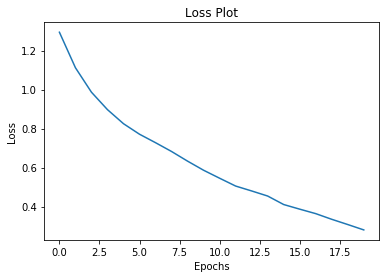

In [43]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [44]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [45]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Real Caption: <start> a man is walking on a street with a backpack while cars pass by <end>
Prediction Caption: a man standing in traffic light in a wet rainy street <end>


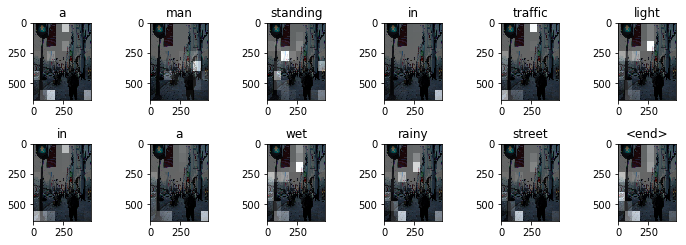

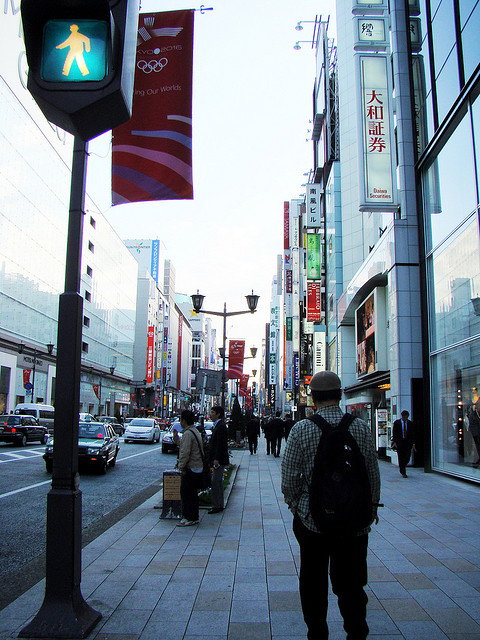

In [54]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])


65536/64400 [==============================] - 0s 0us/step
Prediction Caption: a surfer how their wave in a wave <end>


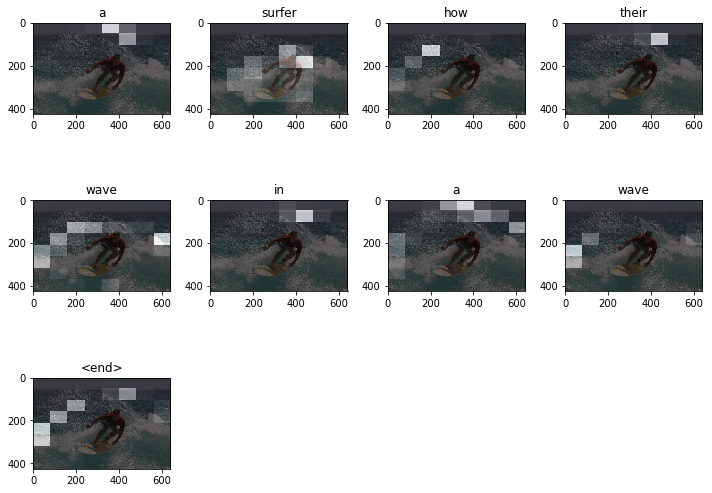

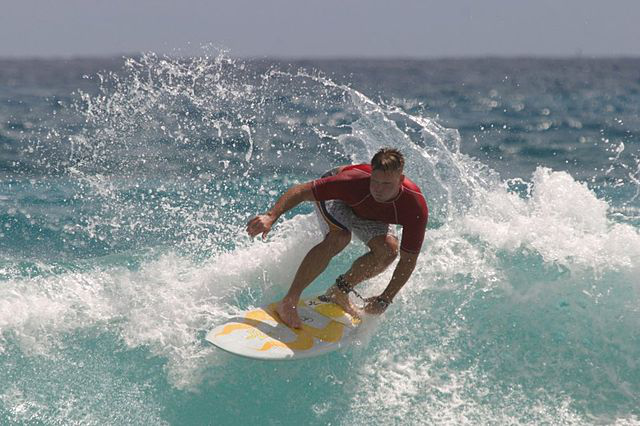

In [55]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)